/home/kianmilani/Projects/apra-howfsc-models/apra_pop_models
6.46 0.8552631578947368


<Quantity 277.69230769 mm>

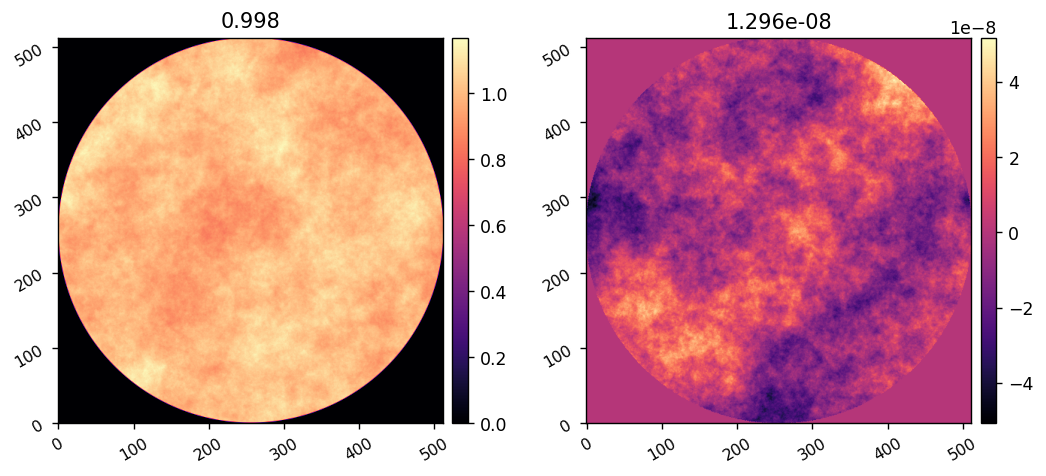

In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload

import poppy
import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

import apra_pop_models
import apra_pop_models.fraunhofer_coro_2dm as fraunhofer
from apra_pop_models.math_module import xp, _scipy, ensure_np_array
import apra_pop_models.utils as utils
import apra_pop_models.efc_utils as efc_utils
import apra_pop_models.efc_2dm as efc

from apra_pop_models.imshows import *

pupil_diam = 9.5*u.mm
wavelength_c = 650e-9*u.m

print(400/500*9.5 * 0.85, 6.5/ (400/500*9.5))

vortex = apra_pop_models.agpm.IdealAGPM(name='VVC', wavelength=wavelength_c, charge=6)

FN = 500
optimal_dm1_dm2 = (pupil_diam**2/(wavelength_c*FN)).to(u.mm)
display(optimal_dm1_dm2)

reload(utils)
wfe = utils.generate_wfe(diam=pupil_diam, npix=512, oversample=1,
                         opd_index=2.75, amp_index=2.75, 
                         opd_seed=123, amp_seed=1234,
                         opd_rms=15*u.nm, amp_rms=0.05, 
                         wavelength=wavelength_c)
CORO_WFE = poppy.ArrayOpticalElement(name='WFE', 
                                     transmission=xp.abs(wfe),
                                     opd=xp.angle(wfe)*wavelength_c.to_value(u.m)/(2*np.pi), 
                                     pixelscale=pupil_diam/(512*u.pix),)

wfe_mask = CORO_WFE.amplitude>0
rms_amp = xp.sqrt(xp.mean(CORO_WFE.amplitude[wfe_mask]**2))
rms_opd = xp.sqrt(xp.mean(CORO_WFE.opd[wfe_mask]**2))
imshow2(CORO_WFE.amplitude, CORO_WFE.opd,  f'{rms_amp:.3f}', f'{rms_opd:.3e}')

Using the influence function supplied.
Including factor of 2 from reflection when computing OPD.
Using the influence function supplied.
Including factor of 2 from reflection when computing OPD.


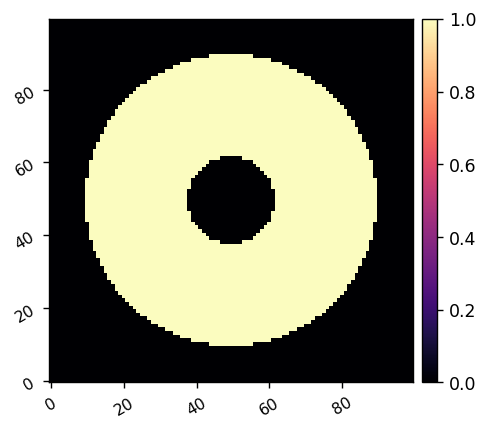

4576


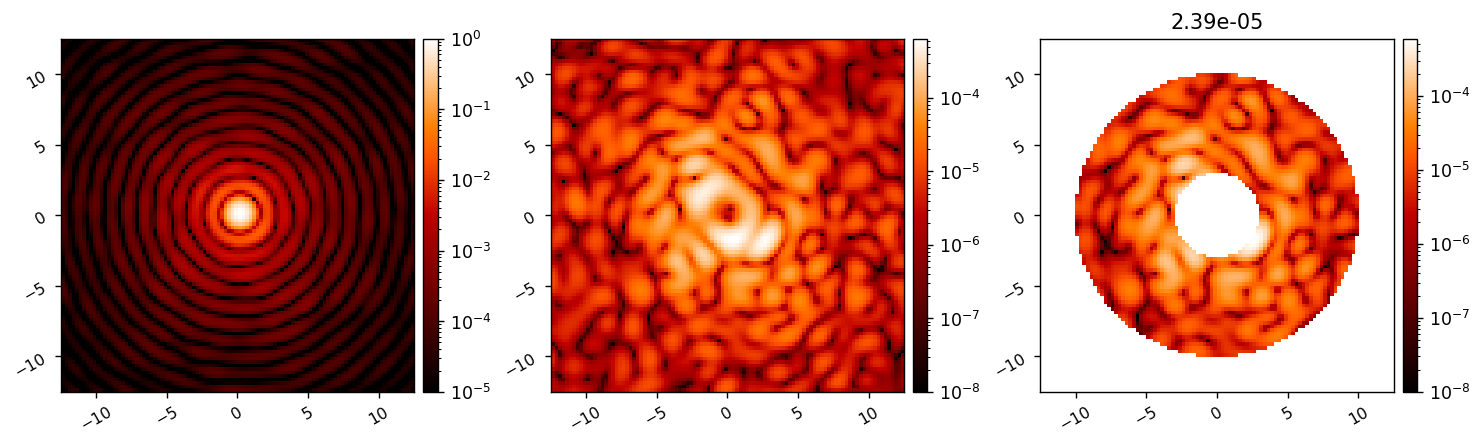

In [2]:
reload(fraunhofer)
model = fraunhofer.CORO(npix=512, oversample=8,
                        pupil_diam=9.5*u.mm,
                        RETRIEVED=CORO_WFE, 
                        )

psf = model.snap()
model.Imax_ref = xp.max(psf)

ref_psf = model.snap()

vortex_phasor = fraunhofer.make_vortex_phase_mask(model.N, 
                                                  singularity=None,
                                                  focal_length=500*u.mm, pupil_diam=model.pupil_diam, 
                                                  wavelength=model.wavelength_c)
model.FPM = vortex_phasor
ref_im = model.snap()

control_mask = efc_utils.create_annular_focal_plane_mask(model, inner_radius=3, outer_radius=10, plot=True)
Nmask = int(control_mask.sum())
print(Nmask)

mean_ni = xp.mean(ref_im[control_mask])

imshow3(ref_psf, ref_im, ref_im*control_mask, '', '', f'{mean_ni:.2e}', 
        lognorm=True, pxscl=model.psf_pixelscale_lamD, 
        vmin1=1e-5, vmin2=1e-8, vmin3=1e-8,
        cmap1='gist_heat', cmap2='gist_heat', cmap3='gist_heat')

In [3]:
poke_modes = efc_utils.create_all_poke_modes(model.dm_mask, ndms=2)


Calculating Jacobian: 
	Calculated response for mode 1904/1904. Elapsed time=341.122 sec.
Jacobian built in 341.122 sec


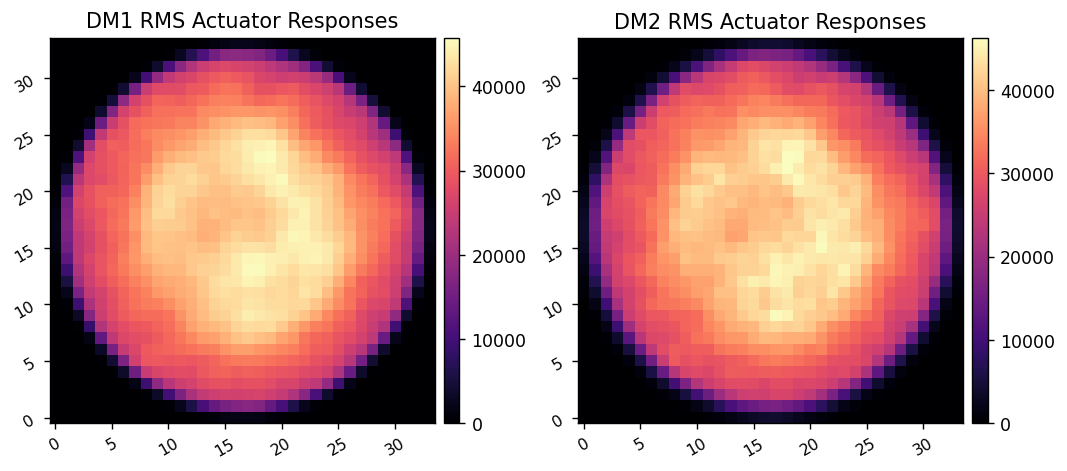

In [4]:
jac = efc.build_jacobian(model, 1e-9, poke_modes, control_mask, plot_responses=True,)

In [19]:
np.linalg.cond(ensure_np_array(jac))/1e12

117.01892950553088

In [11]:
model.reset_dms()

images = xp.array([ref_im])
dm1_commands = xp.array([model.get_dm1()])
dm2_commands = xp.array([model.get_dm2()])
regs = xp.array([])

Beginning closed-loop EFC simulation.
	Running iteration 13/15.


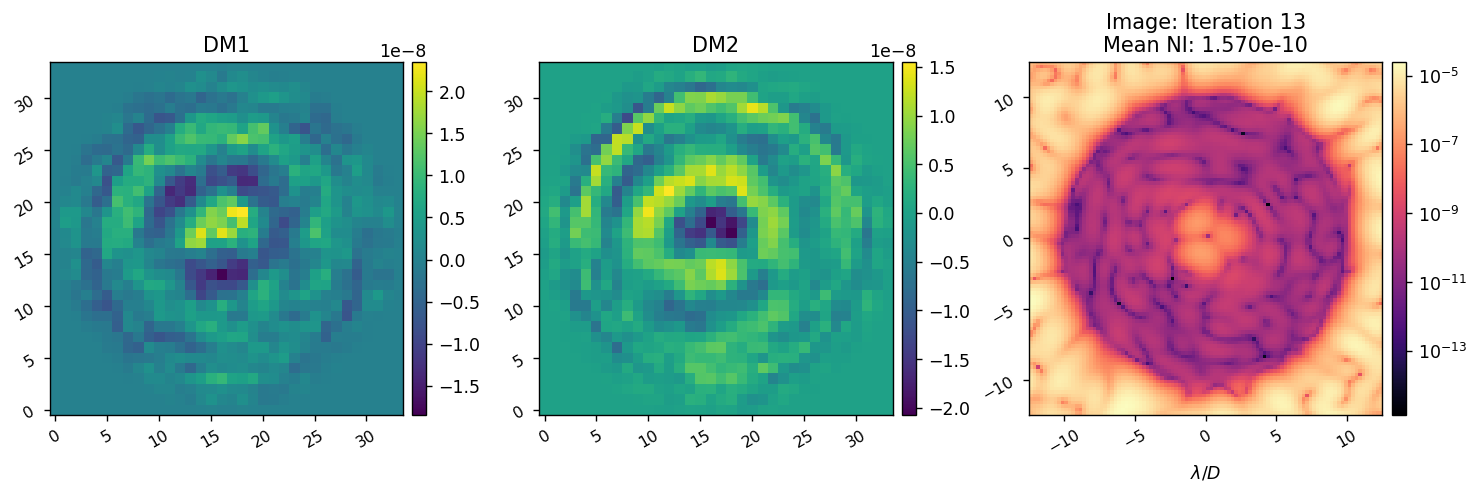

	Running iteration 14/15.


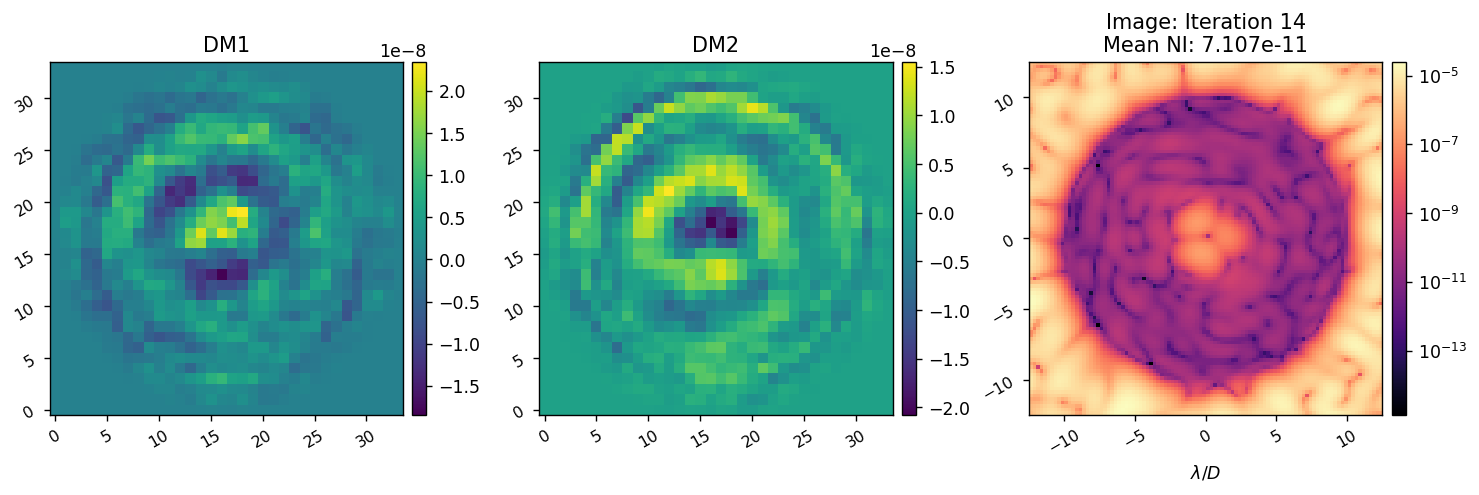

	Running iteration 15/15.


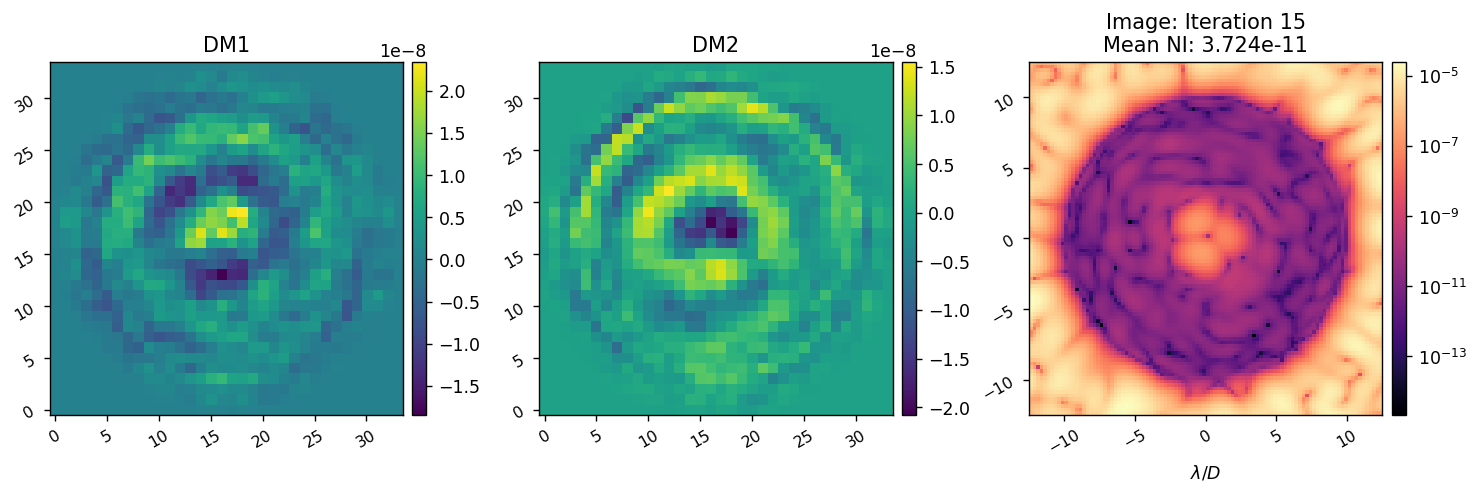

EFC completed in 2.324 sec.


In [16]:
reload(efc)

reg_fun = efc_utils.beta_reg
# reg_conds = -1
reg_conds = -2.5
# reg_conds = -3.5
# reg_conds = -4.5
# reg_conds = -5

images, dm1_commands, dm2_commands, regs = efc.run_efc_perfect(model, 
                                                                jac, 
                                                                reg_fun, reg_conds,
                                                                poke_modes,
                                                                # control_matrix,
                                                                control_mask, 
                                                                # est_fun=pwp_fun, est_params=pwp_params,
                                                                # nonlin_model=nonlin_model,  
                                                                Imax_unocc=1,
                                                                loop_gain=0.5, 
                                                                leakage=0.0,
                                                                iterations=3, 
                                                                plot_all=True, 
                                                                # plot_sms=True,
                                                                # plot_radial_contrast=True,
                                                                old_images=images,
                                                                old_dm1_commands=dm1_commands,
                                                                old_dm2_commands=dm2_commands,
                                                                old_regs=regs,
                                                                )